# Classification Case Study : Predicting Term Deposit Subscription

### Group 15

Members:
1. **Roy Wong** s3835352
2. **Chee Yong** s3759758

## Table of Contents
 
  * [Introduction](#Introduction) 
    + [Report Overview](#Overview) 
    + [Overview of Methodology](#Methodology) 
  * [Predictive Modelling](#Modelling) 
    + [Data Cleaning & Preprocessing](#Data_cleaning)
      - [One hot encoding](#one)
      - [Scaling of features](#scaling)
      - [Splitting Data into Training and Test Sets](#splitting)
    + [Feature Ranking](#Ranking) 
    + [Feature Selection](#Selection) 
    + [Model Fitting & Tuning](#Fitting) 
      - [K-Nearest Neighbors (KNN)](#KNN)
      - [Gaussian Naive Bayes (NB)](#NB)
      - [Decision Trees (DT)](#DT)
      - [Random Forest Tree(RFT)](#RFT)
    + [Model Comparison](#Comparison)
      - [Area under ROC curve](#ROC)
      - [Recall Scores](#Recall)
      - [Confusion matrices](#Confusion)
  * [References](#References) 

## Introduction <a id='Introduction'></a>

### Report Overview <a name='Overview'></a>

Bank capital is an important instrument as it can be used by the bank to repay its depositors, customers and other claimants in case the bank does not have enough liquidity due to losses it suffered in its operations. Furthermore, excess capital can be an essential indicator of the bank’s solvency and probability of non-failure. Term deposits are a vital source of capital for banks.

The target feature in this project is the attribute `subscription`. The objective of this project is to compare and fit various binary classifiers models in order to predict whether a client will subscribe to the term deposit based on the most relevant descriptive features. The hyperparameter of each model is determined and fine tuned. 

The goals of this project is to identify the optimal model based on the best area under ROC curve metrics and allow the deployment of the most accurate model, allowing the bank to target the potential customer in their marketing campaign effectively.

### Overview of Methodology <a id='Methodology'></a>

The modeling process begins with transformation of the raw dataset, which involves encoding of categorical descriptive features and then scaling of the descriptive features. The transformed dataset is then split into `training set` and `test set` with a 70:30 ratio, i.e. 3164 rows of the dataset is treated as `training set` while the other 1357 rows are considered as`test set`. Stratification is applied for the splitting due to imbalance proportion of target feature.

For our project, four different types of algorithm are considered:
- information based learning algorithm, which are the Decision Trees (DT) and Random Forest Tree (RFT)
- similarity based learning algorithm, which is the K-Nearest Neighbors (KNN)
- probability based learning, which is the Gaussian Naive Bayes (NB)

Before fitting of the above classifier model onto the training data, the 10 best features are determined using the F-score. The F-Score is a filter selection method that looks at the relationship between each descriptive feature and the target feature using the F-distribution. The optimal set of hyperparameter value for each model are then identified through a grid search using the features selected. These tuned classifier models are then fitted onto the test data using 5-fold cross validation method. The area under ROC curve for each combination paired models are evaluated, and paired t-tests are conducted to determine whether any performance difference is statistically significant. The recall scores and confusion matrices of each model are also explored in order to consider the optimal metrics.

## Predictive Modelling <a id='Modelling'></a>

### Data Cleaning & Preprocessing<a id='Data_cleaning'></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None) 

bank = pd.read_csv("bank_cleaned_data.csv")

In [2]:
print(f"The shape of the raw dataset is {bank.shape}.")
bank.head(5)

The shape of the raw dataset is (4521, 17).


,age,agegroup,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscription
0,30,Adult,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,0,0,unknown,no
1,33,Adult,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,1,4,failure,no
2,35,Adult,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,1,1,failure,no
3,30,Adult,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,0,0,unknown,no
4,59,Adult,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,0,0,unknown,no


#### One hot encoding<a id='one'></a>

In [3]:
bank_model = bank[['age', 'agegroup', 'job', 'marital', 'education', 'default', 'balance',
                   'housing', 'loan', 'contact', 'day', 'month', 'campaign',
                   'pdays', 'previous', 'poutcome', 'subscription']]


# get the list of categorical descriptive features
categorical_cols = bank_model.columns[bank_model.dtypes==object].tolist()


# For feature with 2 levels, only binary variable is executed
for col in categorical_cols:
    n = len(bank_model[col].unique())
    if (n == 2):
        bank_model[col] = pd.get_dummies(bank_model[col], drop_first=True)

        
# for the rest of the categorical features (i.e more than 2 levels), one-hot-encoding is executed
# and the numerical features will be untouched
bank_dum = pd.get_dummies(bank_model)

In [4]:
print(f"The shape of the encoded dataset is {bank_dum.shape}.")
bank_dum.head(5)

The shape of the encoded dataset is (4521, 51).


,age,default,balance,housing,loan,day,campaign,pdays,previous,subscription,agegroup_Adult,agegroup_Senior,agegroup_Teen,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,33,0,4789,1,1,11,1,1,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,35,0,1350,1,0,16,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,30,0,1476,1,1,3,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,59,0,0,1,0,5,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [5]:
Data = bank_dum.drop(columns='subscription')
target = bank_dum['subscription']

target.value_counts()

0    4000
1     521
Name: subscription, dtype: int64

#### Scaling of features<a id='scaling'></a>

In [6]:
from sklearn import preprocessing

Data_numpy = preprocessing.MinMaxScaler().fit_transform(Data)

#### Splitting Data into Training and Test Sets<a id='splitting'></a>

In [7]:
from sklearn.model_selection import train_test_split


D_train, D_test, t_train, t_test = \
    train_test_split(Data_numpy, target, test_size = 0.3, 
                     stratify=target, shuffle=True, random_state=999)


print(f"The shape of the training set is {D_train.shape}.")
print(f"The shape of the test set is {D_test.shape}.")

The shape of the training set is (3164, 50).
The shape of the test set is (1357, 50).


### Feature Ranking <a id='Ranking'></a>

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

bank_dum_new = bank_dum.copy()
X = bank_dum_new.drop(columns = 'subscription').values
y = bank_dum_new['subscription'].values
col_num = X.shape[1]

new_Ind = []
cur_Maxscore = 0.0
col_Ind_Random = shuffle(range(0,col_num), random_state = 0)


# scoring the accuracy of the model with 
# different amount of features
for cur_f in range(0, col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = X[:, new_Ind].copy()
    X_train, X_test, y_train, y_test = train_test_split(newData, y, test_size=0.3, random_state=999)
    clf = KNeighborsClassifier(3)
    fit = clf.fit(X_train, y_train)
    cur_Score = clf.score(X_test, y_test)
    
    if cur_Score < cur_Maxscore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_Maxscore = cur_Score
        print("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))

Score with 1 selected features: 0.8761974944731025
Score with 2 selected features: 0.8761974944731025
Score with 3 selected features: 0.8761974944731025
Score with 4 selected features: 0.8761974944731025
Score with 5 selected features: 0.8761974944731025
Score with 6 selected features: 0.8761974944731025
Score with 7 selected features: 0.8761974944731025
Score with 8 selected features: 0.8761974944731025
Score with 9 selected features: 0.8761974944731025
Score with 10 selected features: 0.8843036109064112
Score with 11 selected features: 0.8857774502579219
Score with 12 selected features: 0.8865143699336773
Score with 13 selected features: 0.8865143699336773
Score with 14 selected features: 0.887988209285188
Score with 15 selected features: 0.887988209285188


The features in our dataset are randomize using `shuffle` from `sklearn` in order to initialize the order of our features to be considered. The number of features that produced the best accuracies are determined through looping these features. The number of features chosen is 10 for our modeling process as higher number will just result in similar accuracy. The features are then selected with a F-Score method.

In [9]:
num_features = 10

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import feature_selection as fs

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data_numpy, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
fs_indices_fscore

array([48, 49,  7, 44, 33, 31,  8, 10,  9,  3])

In [11]:
best_features_fscore = Data.columns[fs_indices_fscore].values
best_features_fscore

array(['poutcome_success', 'poutcome_unknown', 'pdays', 'month_oct',
       'contact_unknown', 'contact_cellular', 'previous',
       'agegroup_Senior', 'agegroup_Adult', 'housing'], dtype=object)

In [12]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([394.88688441, 121.85116829, 121.85116829,  98.37510624,
        89.55406135,  64.6488446 ,  62.40914419,  55.96857788,
        53.49377224,  50.07068337])

In [13]:
important_features = pd.DataFrame({"Features": best_features_fscore,
                                  "F-Score":feature_importances_fscore})
important_features.round(3)

,Features,F-Score
0,poutcome_success,394.887
1,poutcome_unknown,121.851
2,pdays,121.851
3,month_oct,98.375
4,contact_unknown,89.554
5,contact_cellular,64.649
6,previous,62.409
7,agegroup_Senior,55.969
8,agegroup_Adult,53.494
9,housing,50.071


The F- importances of these features are given as above.

Based on the F-Scores, it is observed that `poutcome_success` is the most important and `housing` is the least important, out of the 10 most important features.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

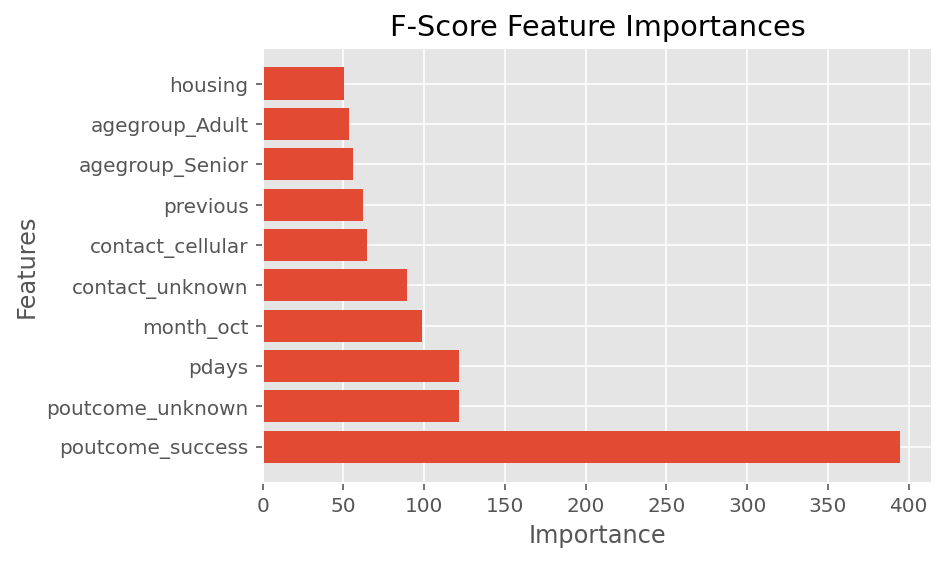

In [15]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

From the F-score plot above, it is observed the most important 5 features are `poutcome_success`, `poutcome_unknown`, `pdays`, `month_oct` and `contact_unknown`.

### Feature Selection <a id='Selection'></a>

For feature selection, the Random Forest Importance (RFI) method is used with 100 estimators to select the best features for our predictive models. This enables `RFI` feature selection as part of the pipeline. Hence, the `RFIFeatureSelector()` is defined in a class to pass in `RFI` as a step to the pipeline.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

Using the following `cv_method`, the models are trained and tuned on 3164 rows of training data and then tested on 1357 rows of our test data. For each model, 5-fold stratified cross-validation evaluation method is used where the cross-validator needs to be repeated three times (`n_repeats` = 3) for hyperparameter tuning.

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [18]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [19]:
#simple performance reporting function
def perform(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

### Model Fitting & Tuning <a id='Fitting'></a>

#### K-Nearest Neighbors (KNN)<a id='KNN'></a>

For KNN hyperparameter tuning, a dictionary for KNN parameters is defined with the grid search. The following parameters are consider:

- k values between 1 and 7 and  
- p-values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski).

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [21]:
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                   'knn__p': [1, 2, 5]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1,
                           return_train_score=True) 

gs_pipe_KNN.fit(D_train, t_train)

Fitting 15 folds for each of 63 candidates, totalling 945 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                         'knn__p': [1, 2, 5],
                         'rfi_fs__n_features_': [10, 20, 50]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [22]:
perform(gs_pipe_KNN, "K Nearest Neighbor ")

K Nearest Neighbor 
Best Score: 0.6328050990901419
Best Parameters: {'knn__n_neighbors': 7, 'knn__p': 1, 'rfi_fs__n_features_': 50}


Based on hyperparameter tuning process above, it is determined that the best parameters for KNN are:

- n_neighbors = 7
- p = 1 (Manhattan)
- n_features = 50

In [23]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
56,0.632805,0.021364,0.677568,0.603058,7.0,1.0,50.0
47,0.627762,0.022582,0.672150,0.600991,6.0,1.0,50.0
42,0.627692,0.032723,0.674566,0.572089,5.0,5.0,10.0
45,0.627256,0.029614,0.700526,0.581873,6.0,1.0,10.0
33,0.626010,0.027979,0.689036,0.572493,4.0,5.0,10.0


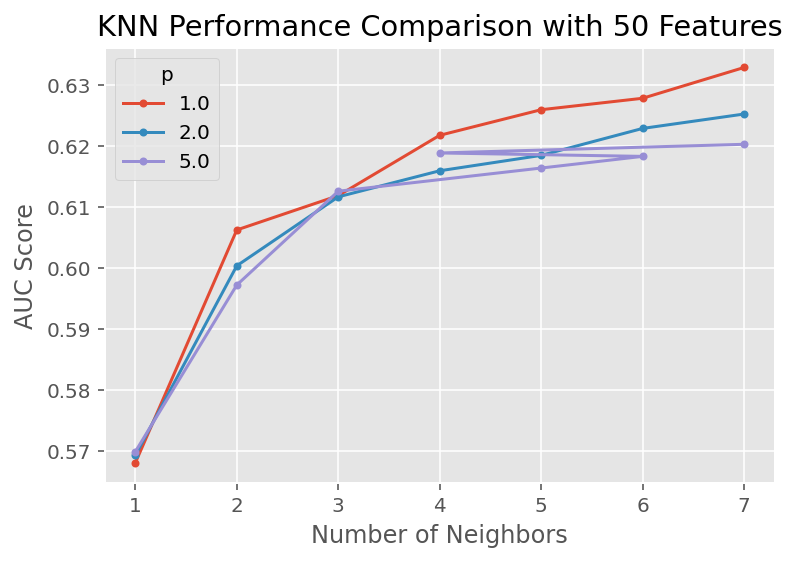

In [24]:
results_KNN_50_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 50.0]

for i in results_KNN_50_features['knn__p'].unique():
    temp = results_KNN_50_features[results_KNN_50_features['knn__p'] == i]
    plt.plot(temp['knn__n_neighbors'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "p")
plt.xlabel('Number of Neighbors')
plt.ylabel("AUC Score")
plt.title("KNN Performance Comparison with 50 Features")
plt.show()

Based on the plot above, the best parameters chosen above resulted in the largest area under the ROC curve.

#### Gaussian Naive Bayes (NB)<a id='NB'></a>

As Gaussian Naive Bayes (NB) requires each descriptive feature to follow a Gaussian distribution, a power transformation on the input data is first performed before fitting the model. Since prior knowledge are unavailable, `var_smoothing` (a variant of Laplace smoothing) is optimized. By default, the `var_smoothing` parameter's value is  $10^{-9}$. A grid search in the `logspace` (over the powers of 10) sourced from `NumPy` is conducted. The value start with 10 and end with  $10^{-2}$  with 100 different values.

In [25]:
from sklearn.preprocessing import PowerTransformer
Data_train_transformed = PowerTransformer().fit_transform(D_train)

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, Data_train_transformed.shape[1]],
                  'nb__var_smoothing': np.logspace(1, -2, num=100)}


gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_NB.fit(Data_train_transformed, t_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
                   estimator=Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                                             ('nb', GaussianNB())]),
                   n_jobs=-2,
                   param_distributions={'nb__var_smoothing': array([10.        ,  9.32603347,  8.69749003,  8.11130831,  7.56463328,
        7.05480231,  6.57933225,  6.13590727,  5.72236766,  5.33669923,
        4.97702356,  4.64158883,...
        0.07564633,  0.07054802,  0.06579332,  0.06135907,  0.05722368,
        0.05336699,  0.04977024,  0.04641589,  0.04328761,  0.04037017,
        0.03764936,  0.03511192,  0.03274549,  0.03053856,  0.02848036,
        0.02656088,  0.02477076,  0.0231013 ,  0.02154435,  0.02009233,
        0.01873817,  0.01747528,  0.01629751,  0.01519911,  0.01417474,
        0.01321941,  0.01232847,  0.01149757,  0.01072267,  0.01      ]),
                                        'rfi_fs__n_featur

In [27]:
perform(gs_pipe_NB, "Gaussian Naive Bayes")

Gaussian Naive Bayes
Best Score: 0.7090138990509331
Best Parameters: {'rfi_fs__n_features_': 50, 'nb__var_smoothing': 0.9326033468832199}


Based on hyperparameter tuning process above, it is determined that the best parameters for NB are:

- n_features = 50
- var_smoothing = 0.933

In [28]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
7,0.709014,0.026753,0.758880,0.669080,50.0,0.932603
5,0.706517,0.026178,0.757118,0.668219,50.0,0.162975
8,0.706009,0.026322,0.757216,0.667018,50.0,0.030539
9,0.692670,0.033357,0.766585,0.636986,20.0,0.231013
1,0.690477,0.026655,0.754220,0.641781,20.0,0.030539


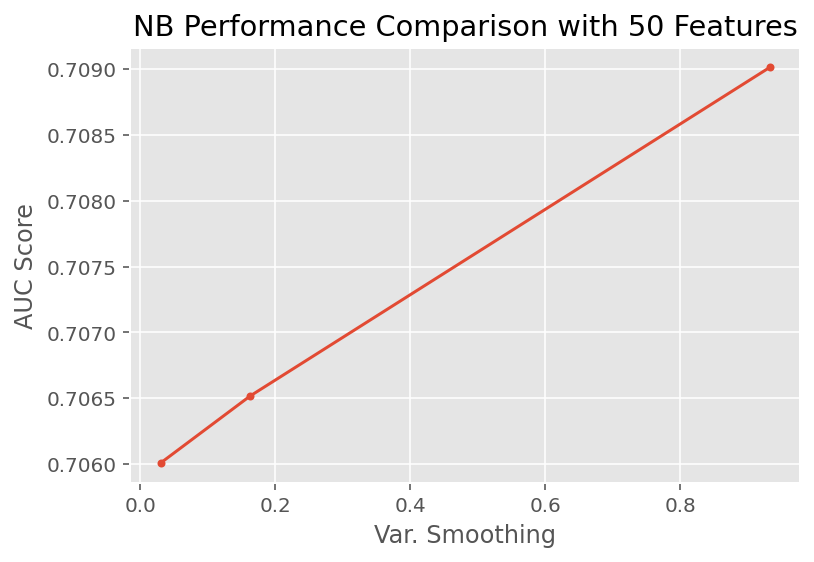

In [29]:
results_NB_50_features = results_NB[results_NB['rfi_fs__n_features_'] == 50.0].sort_values('nb__var_smoothing')

plt.plot(results_NB_50_features['nb__var_smoothing'], results_NB_50_features['mean_score'], marker = '.', label = i)    
plt.xlabel('Var. Smoothing')
plt.ylabel("AUC Score")
plt.title("NB Performance Comparison with 50 Features")
plt.show()

Based on the plot above, the best parameters chosen above resulted in the largest area under the ROC curve.

#### Decision Trees (DT)<a id='DT'></a>

The Decision Trees (DT) Classifier is built using entropy as the criteria to maximize information gain. The aim of this model is to determine the optimal combinations of maximum depth (`max_depth`) and minimum sample split (`min_samples_split`).

In [30]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='entropy', random_state=999))])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'dt__max_depth': [3, 4, 5],
                  'dt__min_samples_split': [2, 5]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(D_train, t_train);

Fitting 15 folds for each of 18 candidates, totalling 270 fits


In [31]:
perform(gs_pipe_DT, "Decision Tree")

Decision Tree
Best Score: 0.6584731552826487
Best Parameters: {'dt__max_depth': 4, 'dt__min_samples_split': 2, 'rfi_fs__n_features_': 50}


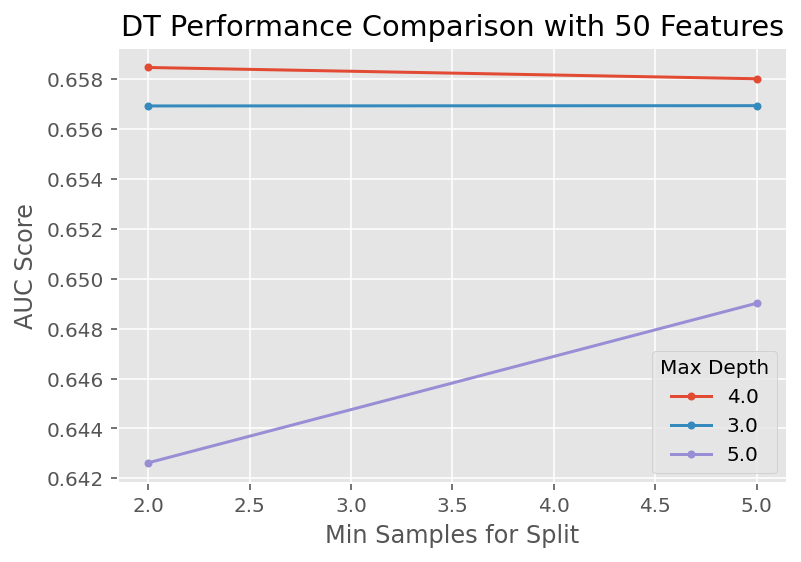

In [32]:
results_DT = get_search_results(gs_pipe_DT)
results_DT_50_features = results_DT[results_DT['rfi_fs__n_features_'] == 50.0]


for i in results_DT_50_features['dt__max_depth'].unique():
    temp = results_DT_50_features[results_DT_50_features['dt__max_depth'] == i]
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("AUC Score")
plt.title("DT Performance Comparison with 50 Features")
plt.show()

#### Further Fine Tuning DT

Based on the result above, it is observed that the optimal value of maximum depth hyperparameter is at the extreme end of its search space. Therefore, a search beyond the range of our initial parameters have to be done in order to ensure that better scores are included. Hence, a new search is done as follows

In [33]:
params_pipe_DT_fine = {'rfi_fs__n_features_': [50],
                       'dt__max_depth': [5, 10, 15, 20],
                       'dt__min_samples_split': [10, 50, 100, 150]}


gs_pipe_DT_fine = GridSearchCV(estimator=pipe_DT, 
                                param_grid=params_pipe_DT_fine, 
                                cv=cv_method,
                                refit=True,
                                n_jobs=-2,
                                scoring='roc_auc',
                                verbose=1) 


gs_pipe_DT_fine.fit(D_train, t_train);

Fitting 15 folds for each of 16 candidates, totalling 240 fits


In [34]:
perform(gs_pipe_DT_fine, 'Decision Tree')

Decision Tree
Best Score: 0.7139883957234228
Best Parameters: {'dt__max_depth': 10, 'dt__min_samples_split': 150, 'rfi_fs__n_features_': 50}


Based on hyperparameter tuning process above, it is determined that the best parameters for DT are:

- max_depth = 10
- min_samples_split: 150
- n_features = 50

In [35]:
results_DT = get_search_results(gs_pipe_DT_fine)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
7,0.713988,0.031597,0.789775,0.654305,10.0,150.0,50.0
15,0.713880,0.029172,0.788148,0.664469,20.0,150.0,50.0
6,0.712891,0.027954,0.775563,0.665827,10.0,100.0,50.0
5,0.712119,0.028875,0.779183,0.662500,10.0,50.0,50.0
11,0.711320,0.031952,0.790423,0.654684,15.0,150.0,50.0


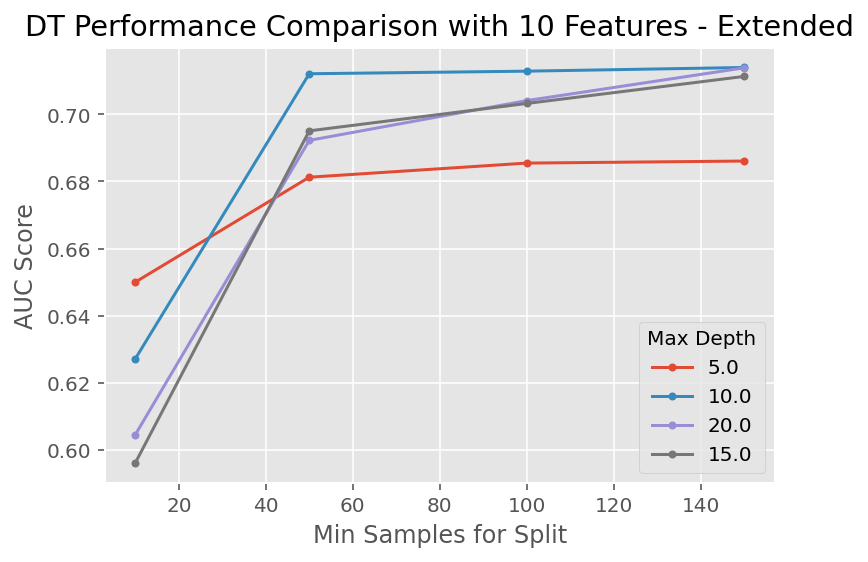

In [36]:
results_DT_50_features = results_DT[results_DT['rfi_fs__n_features_'] == 50.0].sort_values('dt__min_samples_split')


for i in results_DT_50_features['dt__max_depth'].unique():
    temp = results_DT_50_features[results_DT_50_features['dt__max_depth'] == i]
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("AUC Score")
plt.title("DT Performance Comparison with 10 Features - Extended")
plt.show()

Based on the plot above, the best parameters chosen above resulted in the largest area under the ROC curve.

#### Random Forest Tree (RFT)<a id='RFT'></a>

For Random Forest Classifier, it is started by setting a large range for the number of estimators and maximum depth for our initial search. Since the total feature space is very large, the range of values are narrowed down by further fine tuning of the model.

In [37]:
from sklearn.ensemble import RandomForestClassifier

pipe_RF = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('rf', RandomForestClassifier(random_state = 999, criterion='entropy'))])

#'rf__max_depth': np.arange(10,30)
params_pipe_RF = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'rf__n_estimators': list(range(100, 300, 50)),
                  'rf__max_depth': list(range(0, 30, 10))}

gs_pipe_RF = GridSearchCV(estimator=pipe_RF, 
                          param_grid=params_pipe_RF, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_RF.fit(D_train, t_train);

Fitting 15 folds for each of 36 candidates, totalling 540 fits


In [38]:
perform(gs_pipe_RF,'Random Forest')

Random Forest
Best Score: 0.7399817404110173
Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 250, 'rfi_fs__n_features_': 50}


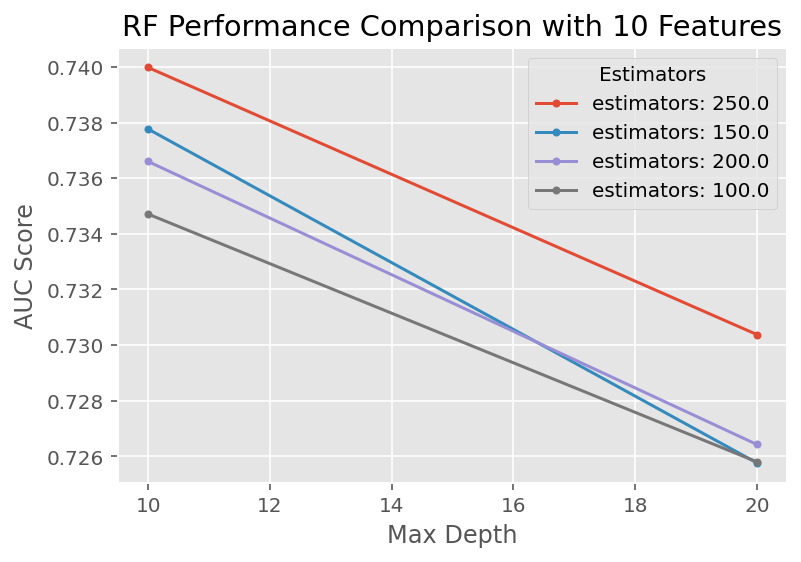

In [39]:
results_RF = get_search_results(gs_pipe_RF)
results_RF_50_features = results_RF[results_RF['rfi_fs__n_features_'] == 50.0]

for i in results_RF_50_features['rf__n_estimators'].unique():
    temp = results_RF_50_features[results_RF_50_features['rf__n_estimators'] == i]
    plt.plot(temp['rf__max_depth'], temp['mean_score'], marker = '.', label = 'estimators: ' + str(i))

plt.legend(title = "Estimators")
plt.xlabel('Max Depth')
plt.ylabel("AUC Score")
plt.title("RF Performance Comparison with 10 Features")
plt.show()

In [40]:
results_RF.head()

,mean_score,std_score,max_score,min_score,rf__max_depth,rf__n_estimators,rfi_fs__n_features_
23,0.739982,0.029008,0.788160,0.690558,10.0,250.0,50.0
17,0.737769,0.026876,0.788272,0.697505,10.0,150.0,50.0
20,0.736602,0.027232,0.785274,0.696086,10.0,200.0,50.0
14,0.734711,0.029920,0.782978,0.688160,10.0,100.0,50.0
35,0.730380,0.029219,0.779033,0.664457,20.0,250.0,50.0


#### Further RFT Fine Tuning

In [41]:
params_pipe_RF_fine = {'rfi_fs__n_features_': [50],
                       'rf__max_depth': [10, 15, 20],
                       'rf__n_estimators': [100, 250, 500]}


gs_pipe_RF_fine = GridSearchCV(estimator=pipe_RF, 
                                param_grid=params_pipe_RF_fine, 
                                cv=cv_method,
                                refit=True,
                                n_jobs=-2,
                                scoring='roc_auc',
                                verbose=1) 


gs_pipe_RF_fine.fit(D_train, t_train);

Fitting 15 folds for each of 9 candidates, totalling 135 fits


In [42]:
perform(gs_pipe_RF_fine, "Random Forest")

Random Forest
Best Score: 0.7389936454646554
Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 500, 'rfi_fs__n_features_': 50}


Based on hyperparameter tuning process above, it is determined that the best parameters for RFT are:

- max_depth = 10
- n_estimators: 500
- n_features = 50

In [43]:
results_RF_tuned = get_search_results(gs_pipe_RF_fine)
results_RF_tuned.head()

,mean_score,std_score,max_score,min_score,rf__max_depth,rf__n_estimators,rfi_fs__n_features_
2,0.738994,0.027667,0.782341,0.690949,10.0,500.0,50.0
1,0.734885,0.029046,0.778694,0.678523,10.0,250.0,50.0
4,0.733663,0.025392,0.787708,0.683390,15.0,250.0,50.0
5,0.733594,0.026391,0.779205,0.683146,15.0,500.0,50.0
0,0.733217,0.029010,0.791047,0.678645,10.0,100.0,50.0


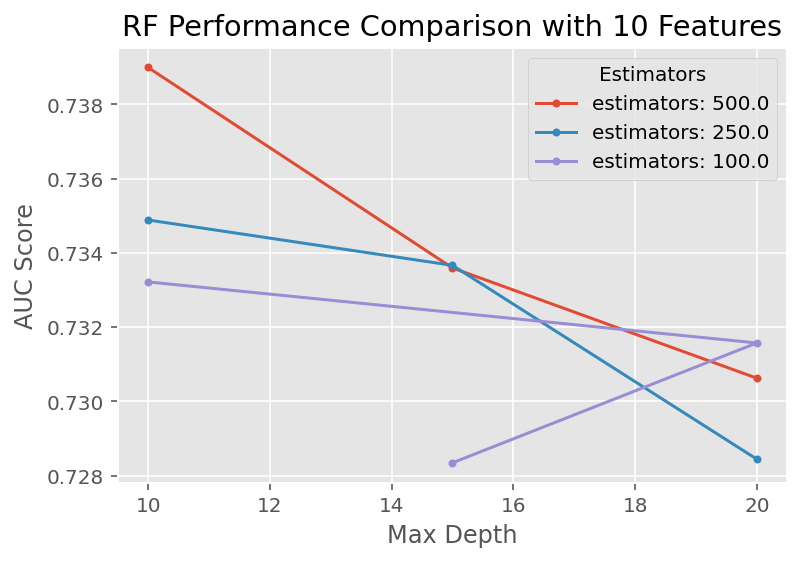

In [44]:
results_RF_tuned_features = results_RF_tuned[results_RF_tuned['rfi_fs__n_features_'] == 50.0]

for i in results_RF_tuned_features['rf__n_estimators'].unique():
    temp = results_RF_tuned_features[results_RF_tuned_features['rf__n_estimators'] == i]
    plt.plot(temp['rf__max_depth'], temp['mean_score'], marker = '.', label = 'estimators: ' + str(i))

plt.legend(title = "Estimators")
plt.xlabel('Max Depth')
plt.ylabel("AUC Score")
plt.title("RF Performance Comparison with 10 Features")
plt.show()

Based on the plot above, the best parameters chosen above resulted in the largest area under the ROC curve.

### Model Comparison <a id='Comparison'></a>

Model evaluation is an essential step in determine the best model and estimate how the models will perform when deployed.

There is no perfect model as the consideration of choosing the right metrics is always problem specific. The models are evaluated with different scoring metrics in order to explore the differences and assist in determining the most suitable ones.

For this project, three different types evaluation metrics are considered:

- Area under ROC curve
- Recall scores
- Confusion Matrices

Also, the dataset is split using a cross-validation approach as this method is more robust.

In [45]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=999, shuffle=True)

#### Area under ROC curve<a id='ROC'></a>

In [46]:
# K-NN results
cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=D_test,
                                 y=t_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.6339282455234161

In [47]:
D_test_transformed = PowerTransformer().fit_transform(D_test)

# Gaussian NB results
cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=D_test_transformed,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

0.7096047405876952

In [48]:
# Decision Tree results
cv_results_DT = cross_val_score(estimator=gs_pipe_DT_fine.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

0.6543810979109275

In [49]:
# Random Forest Tree results
cv_results_RF = cross_val_score(estimator=gs_pipe_RF_fine.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_RF.mean()

0.732357438016529

In [50]:
from scipy import stats

print('\nRF vs. KNN')
print(stats.ttest_rel(cv_results_RF, cv_results_KNN))  
print('\nRF vs. NB')
print(stats.ttest_rel(cv_results_RF, cv_results_NB)) 
print('\nRF vs. DT')
print(stats.ttest_rel(cv_results_RF, cv_results_DT)) 
print('\nDT vs. NB')
print(stats.ttest_rel(cv_results_DT, cv_results_NB)) 
print('\nDT vs. KNN')
print(stats.ttest_rel(cv_results_DT, cv_results_KNN)) 
print('\nNB vs. KNN')
print(stats.ttest_rel(cv_results_NB, cv_results_KNN)) 


RF vs. KNN
Ttest_relResult(statistic=5.125465345106235, pvalue=0.0006233716788971571)

RF vs. NB
Ttest_relResult(statistic=1.3969451082690543, pvalue=0.1959155635889577)

RF vs. DT
Ttest_relResult(statistic=2.7087729579315294, pvalue=0.02404576028422854)

DT vs. NB
Ttest_relResult(statistic=-1.5654358029447684, pvalue=0.1519212645787582)

DT vs. KNN
Ttest_relResult(statistic=0.7865736055053008, pvalue=0.45174485871630576)

NB vs. KNN
Ttest_relResult(statistic=4.1118439466006835, pvalue=0.002629760811646573)


Based on the results above, the following can be deduced:

- The difference between Random Forest Tree and KNN is significant at 5% significant test. Random Forest Classifier is evidenced to perform better as compared to KNN.

- The difference between Random Forest Tree and Gaussian Naive Bayes is insignificant at 5% significant test. The performance in terms of area under ROC curve is evidenced to be indifference.

- The difference between Random Forest Tree and Decision Tree is significant at 5% significant test. Random Forest Classifier is evidenced to perform better as compared to Decision Tree Classifier.

- The difference between Decision Tree and Gaussian Naive Bayes is insignificant at 5% significant test. The performance in terms of area under ROC curve is evidenced to be indifference.

- The difference between Decision Tree and KNN is insignificant at 5% significant test. The performance in terms of area under ROC curve is evidenced to be indifference.

- The difference between Gaussian Naive Bayes and KNN is significant at 5% significant test. Gaussian NB Classifier is  evidenced to perform better as compared to KNN.

#### Recall scores<a id='Recall'></a>

In [51]:
pred_KNN = gs_pipe_KNN.predict(D_test)

In [52]:
D_test_transformed = PowerTransformer().fit_transform(D_test)
pred_NB = gs_pipe_NB.predict(D_test_transformed)

In [53]:
pred_DT = gs_pipe_DT_fine.predict(D_test)

In [54]:
pred_RF = gs_pipe_RF_fine.predict(D_test)

In [55]:
from sklearn import metrics

print("\nClassification report for K-NN") 
print(metrics.classification_report(t_test, pred_KNN))
print("\nClassification report for Gaussian NB") 
print(metrics.classification_report(t_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(t_test, pred_DT))
print("\nClassification report for Random Forest") 
print(metrics.classification_report(t_test, pred_RF))


Classification report for K-NN
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1201
           1       0.40      0.05      0.09       156

    accuracy                           0.88      1357
   macro avg       0.64      0.52      0.51      1357
weighted avg       0.83      0.88      0.84      1357


Classification report for Gaussian NB
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1201
           1       0.39      0.30      0.34       156

    accuracy                           0.87      1357
   macro avg       0.65      0.62      0.63      1357
weighted avg       0.85      0.87      0.86      1357


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1201
           1       0.55      0.15      0.23       156

    accuracy                           0.89      1357
   macro avg    

#### Confusion matrices<a id='Confusion'></a>

In [56]:
from sklearn import metrics
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(t_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(t_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(t_test, pred_DT))
print("\nConfusion matrix for Random Forest") 
print(metrics.confusion_matrix(t_test, pred_RF))


Confusion matrix for K-Nearest Neighbor
[[1189   12]
 [ 148    8]]

Confusion matrix for Naive Bayes
[[1128   73]
 [ 109   47]]

Confusion matrix for Decision Tree
[[1182   19]
 [ 133   23]]

Confusion matrix for Random Forest
[[1194    7]
 [ 147    9]]


Based on the recall scores from the Classification Report and Confusion Matrix above , it is determined that Gaussian NB Classifier is the best model which has the highest true positive rate (`TPR`) of 30%. However, if compared by the F1- score metrics, Decision Tree Classifier and Random Forest Tree classifiers both produce the highest accuracy of 89%.

## References <a id='References'></a>

- Classification Case Study | www.featureranking.com. (2021). Retrieved 6 May 2021, from https://www.featureranking.com/tutorials/machine-learning-tutorials/case-study-predicting-income-status/#5
- sklearn.model_selection.RepeatedStratifiedKFold — scikit-learn 0.24.2 documentation. (2021). Retrieved 29 May 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html
- UCI Machine Learning Repository: Bank Marketing Data Set. (2021). Retrieved 21 March 2021, from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing